In [1]:
import pandas as pd
import numpy as np
import math
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define models to fit to

# E/B = B / (mc^2/re)
def classical(x, a):
    return x/a

# E/B = B / sqrt((mc^2/re)^2 + B^2)
def relativistic(x, a):
    return x/(a**2+x**2)**.5

def gaussian(x, a, m, s):
    return a * np.exp(-(x-m)**2/(2*s**2))

In [2]:
def fit_model(x ,y, ey, p0, model):
    # fit data to model
    popt, pcov = opt.curve_fit(f=model, xdata=x, ydata=y, p0=p0, sigma=ey, absolute_sigma=True)
    
    # calculate error on parameters
    perr = np.sqrt(np.diag(pcov))
    
    # calculate chi sq value
    r = np.array([yi - model(xi, *popt) for (xi, yi) in zip(x, y)])
    chisq = sum((r / ey)**2)
    
    return popt, perr, chisq

In [26]:
def init_plot():
    plt.figure(figsize=(8.6,7))
    matplotlib.rcParams.update({'font.size': 16})
    
def plot_data(x, y, ey):
    plt.errorbar(x, y, yerr=ey, fmt='o')
    
def plot_model(x, model, p, color, label):
        plt.plot(x, [model(xi, *p) for xi in x] , color=color, linewidth=2.5, label=label)
    
# plot helper function. meant to be changed
def plot(x, y, ey, model, p):
    init_plot()
    
    plot_data(x, y, ey)
    plot_model(x, model, p, 'r', '$ae^{-(x-\mu)/2\sigma^2}$')
    
    plt.xlabel('Capacitor Voltage (kV)')
    plt.ylabel('counts / sec')
    # 0.78367346  3.17221718  0.24440867] [ 0.04773445  0.01476693  0.01802811] 14.8814231936
    plt.text(2.85, .9, '$a=.784\pm.048$\n$\mu=3.172\pm.014$\n$\sigma=.244\pm.018$\n$\chi^2=14.88$')
    plt.legend()
    
    plt.grid(True)
    
    #plt.savefig('reldyn/90.png')
    plt.show()
    
def multiplot(x, y, ey, model1, p1, model2, p2):
    init_plot()
    
    plot_data(x, y, ey)
    plot_model(x, model1, p1, 'r', 'classical fit. reduced $\chi^2 = 0.34$')
    plot_model(x, model2, p2, 'k', 'relativistic fit. reduced $\chi^2 = 0.06$')
    
    plt.xlabel('B (G)')
    plt.ylabel('E/B (statV/cm/G)')
    plt.legend()
    
    #plt.savefig('reldyn/data_fits.png')
    
    plt.show()

In [5]:
# load data 
x, y, ey = {}, {}, {}
raw_data = pd.read_csv('reldyn.csv').set_index('type')
bs = list(raw_data)
print(bs)
for b in bs:
    x[b] = [float(i) for i in raw_data[b]['x'].split(', ')]
    y[b] = [float(i) for i in raw_data[b]['y'].split(', ')]
    ey[b] = [float(i) for i in raw_data[b]['ey'].split(', ')]
    

['40', '50', '60', '70', '80', '90', '100']


B = 40
[ 2.8223831   0.81871834  0.4491367 ] [ 0.09161405  0.03575969  0.07416238] 15.6888776357
------------------------------
B = 50
[ 0.23928808  1.37780334  0.26711269] [ 0.02448997  0.02655379  0.03046529] 1.02373495912
------------------------------
B = 60
[ 0.26065777  1.8507577   0.14370323] [ 0.03129821  0.01615998  0.01507018] 1.34781979158
------------------------------
B = 70
[ 0.3314698   2.35451857  0.26879869] [ 0.0288762   0.02079297  0.02294439] 1.10800469401
------------------------------
B = 80
[ 0.51177824  2.6322359   0.233391  ] [ 0.0384549   0.01672861  0.01930723] 0.495349713916
------------------------------
B = 90
[ 0.78367346  3.17221718  0.24440867] [ 0.04773445  0.01476693  0.01802811] 1.24011859947
------------------------------
B = 100
[ 0.95186043  3.58474614  0.43029529] [ 0.04228415  0.0532606   0.04978061] 2.6737843785
------------------------------


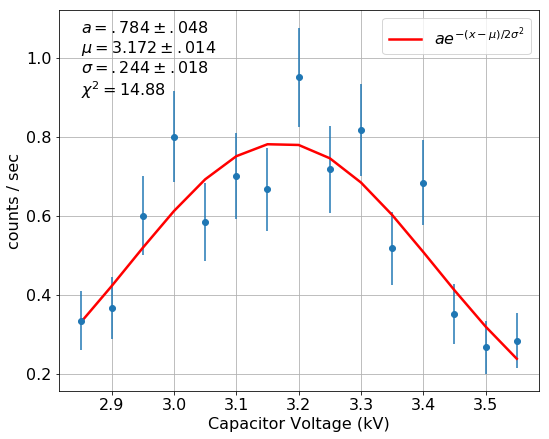

In [7]:
# optimize gaussian for each B field
popt, perr, chisq = {}, {}, {}
for b in bs:
    print("B =", b) 
    
    # generate p0 according to a silly approximation
    p0 = (10, .025*int(b)+.4, .3)

    popt[b], perr[b], chisq[b] = fit_model(x=x[b], y=y[b], ey=ey[b], p0=p0, model=gaussian)
    
    print(popt[b], perr[b], chisq[b]/(len(x[b])-3))
    #plot(x[b], y[b], ey[b], gaussian, popt[b])
    print('------------------------------')
    
plot(x['90'], y['90'], ey['90'], gaussian, popt['90'])

In [17]:
# make list of B (p), E/B (v), and error in E/B (ev) based on fitted gaussians
p = [int(i) for i in list(popt.keys())]

# scale B by the factor we found through calibration
adj_p = [0.9452322125*i for i in p]

# [E]/B = [voltage(kV) * conversion (statv/kV) / separation (cm)] / B (G)
v = [popt[str(p[i])][1]* 3.3356409519815 / 0.18 / adj_p[i] for i in range(len(p))] # need to take into account the error...

# error on E/B = sqrt(% voltage err^2 + % B error^2 + % separation error^2)
ev = [(((popt[str(p[i])][2]+.1)/popt[str(p[i])][1])**2 
       + (.7/adj_p[i])**2 
       + (.003/.18)**2) **.5 
      for i in range(len(p))]

print(adj_p, '\n', v, '\n', ev)

[37.8092885, 47.261610625, 56.71393275, 66.166254875, 75.618577, 85.070899125, 94.52322125] 
 [0.4012756491884647, 0.54023846942731257, 0.60473707111447517, 0.65943555367287376, 0.64506443680038528, 0.69101692085294053, 0.70279179790969848] 
 [0.67118968366930598, 0.26737910592918573, 0.13330076712217487, 0.15787351902222893, 0.12808378130492454, 0.11014990532994938, 0.14905105886290126]


[ 116.81872941] [ 10.35058424] 0.340327884589
[ 83.88375799] [ 13.30908573] 0.0626486432076


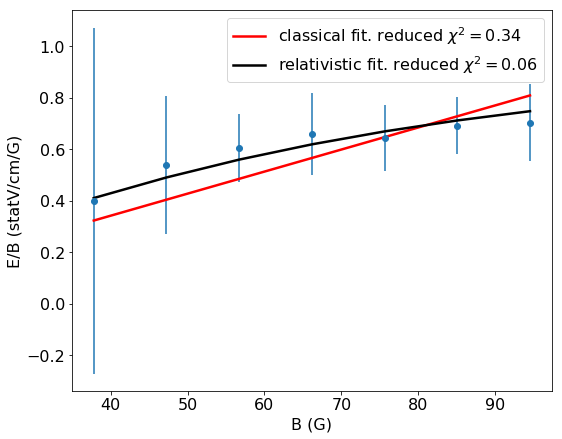

In [25]:
# calculate and plot fits

cls_p, cls_perr, cls_chisq = fit_model(adj_p, v, ev, (83.97157), classical)
#multiplot(adj_p, v, ev, classical, cls_p, classical, [83.97157])
print(cls_p, cls_perr, cls_chisq/6)

rel_p, rel_perr, rel_chisq = fit_model(adj_p, v, ev, (83.97157), relativistic)
#multiplot(adj_p, v, ev, relativistic, rel_p, relativistic, [83.97157])
print(rel_p, rel_perr, rel_chisq/6)

multiplot(adj_p, v, ev, classical, [cls_p], relativistic, [rel_p])